# Penorama

Here I stitched two images of the same scene from different angle. In short, the steps are: 
1. find keypoints in both images with SIFT feature, 
2. match the keypoints, 
3. compute the homography matrix with RANSAC, 
4. project both images in the same canvas, 
5. use Laplacian pyramid to blend the image.

First, view the 3 images in gray scale

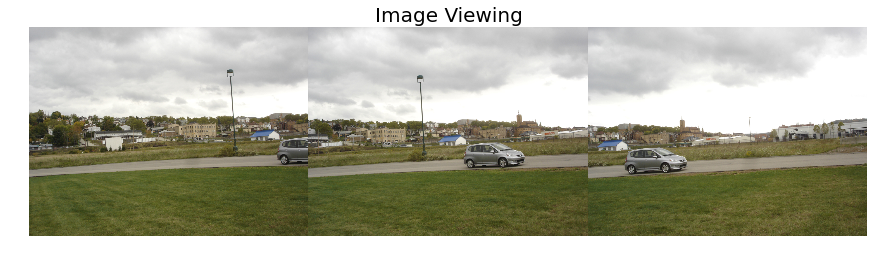

In [20]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.io import imread

# Grayscale images
img1 = cv2.imread('I1.jpg',0)
img2 = cv2.imread('I2.jpg',0)
img3 = cv2.imread('I3.jpg',0)

# Color images with 3 channels
img1_c = imread('I1.jpg')
img2_c = imread('I2.jpg')
img3_c = imread('I3.jpg')

def read_show_image(img,n):
    axes[n-1].imshow(img, cmap = cm.Greys_r)
    axes[n-1].set_title('Image '+str(n),fontsize=20)
    axes[n-1].axis('off')

def display(img,st):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap = cm.Greys_r)
    plt.title(st,fontsize = 20)
    plt.axis('off')
    plt.show()

imcon_3 = np.concatenate((img1_c, img2_c, img3_c), axis=1)
display(imcon_3,'Image Viewing')

### Detection

Detect the key points in image 1 and image 2 using SIFT feature, and draw a small circle around the interest points. As shown in the image below, key points are mostly around the edges and where the color changes significantly. 

Sample Description Feature Vector of a (1558, 128) Description Matrix
[   7.   54.   36.    0.    0.    0.    0.    0.   39.  158.   41.    0.
    0.    0.    0.    0.  112.  129.    7.    0.    0.    0.    0.    0.
   21.    8.    0.    0.    0.    0.    0.    2.    4.   36.   20.    2.
    0.    0.    0.    0.   70.   90.   37.   13.    0.    0.    0.    0.
  158.   89.    3.    0.    0.    0.    0.    9.   47.    1.    0.    0.
    0.    0.    3.    9.    0.   24.   42.    1.    0.    0.   25.    7.
  125.   19.   30.   11.    0.    0.   28.   26.  158.    9.    1.    0.
    0.    0.    1.   56.   41.    0.    0.    0.    0.    1.    7.   12.
    0.    1.    1.    0.    0.    2.  158.   63.   47.    1.    1.    0.
    7.   46.  158.   65.  158.    0.    0.    0.    1.    7.   19.   97.
   20.    0.    0.    0.    0.    1.    9.   10.]
Sample Description Feature Vector of a (1448, 128) Description Matrix
[   7.   51.   34.    0.    0.    0.    0.    0.   25.  158.   46.    0.
    0. 

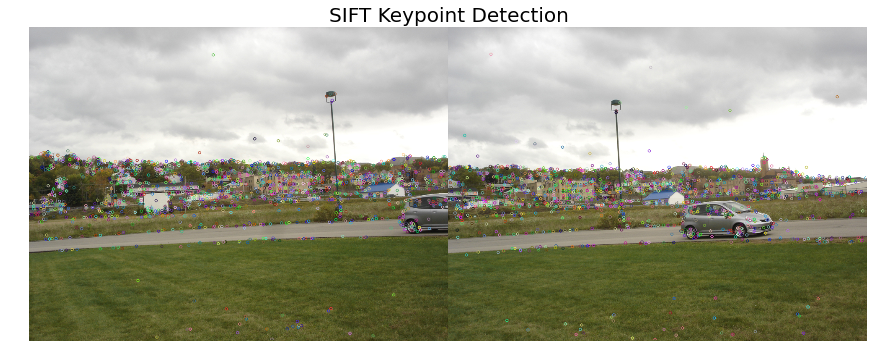

In [21]:
sift = cv2.xfeatures2d.SIFT_create()

def draw_sift_kp(img):
    kp, des = sift.detectAndCompute(img,None)
    img_kp = img.copy()
    img_kp = cv2.drawKeypoints(img,kp,img_kp)
    print 'Sample Description Feature Vector of a',des.shape,'Description Matrix'
    print des[0]
    return img_kp

img1_kp = draw_sift_kp(img1_c)
img2_kp = draw_sift_kp(img2_c)

imcon_2_kp = np.concatenate((img1_kp, img2_kp), axis=1)
display(imcon_2_kp,'SIFT Keypoint Detection')

### Matching

We used ORB for SIFT detector as an efficient alternative, and also because ORB has a better implementation in opencv 3.0. We use drawMatches function to display the first 50 mathches out of 200+. The result shows that best matches happens arround the lamp and houses in the background instead of the car, probably because that the edges and corners are more accurate keypoints. 

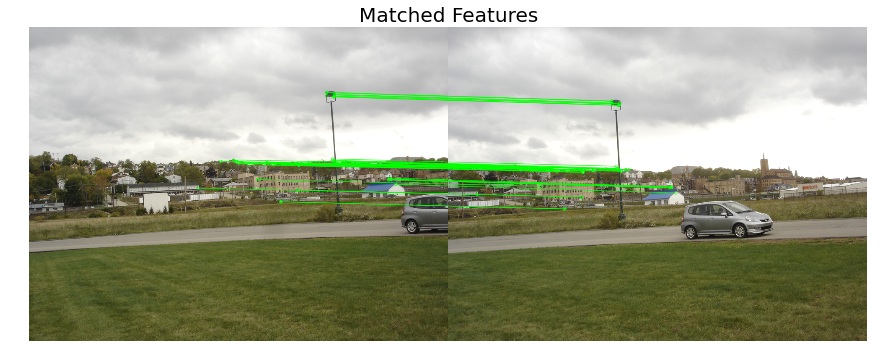

In [53]:
# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 50 matches.
imcon_2 = np.concatenate((img1_c, img2_c), axis=1)
img_m = imcon_2.copy()
img_match = cv2.drawMatches(img1_c,kp1,img2_c,kp2,matches[:50],img_m,matchColor = (0,255,0), flags=2)

display(img_match,'Matched Features')

### Homography and Mapping

First, a minimum matches number of 10 must be satisfied before the RANSAC homograph process. Then we used the key point coordinates in query image (which is image 1) and train image (which is image 2) to calculate the Homography matrix H and a much more precise match mask. Then we used perspectiveTransform function to project image 1 according to the homograph matrix H, and draw the edges (of the overlapping part) on image 2. 

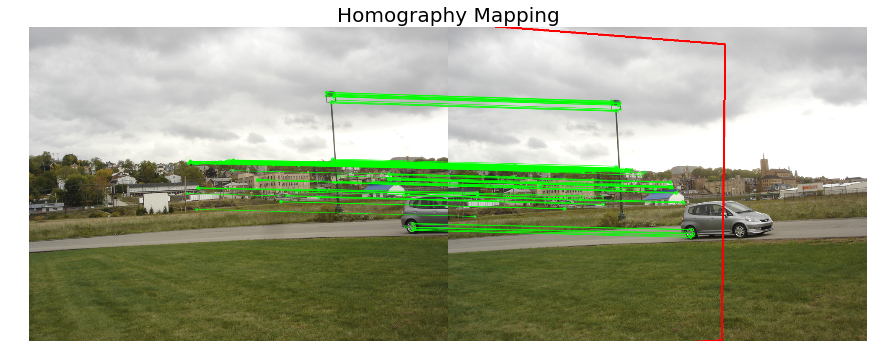

In [52]:
MIN_MATCH_COUNT = 10

if len(matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    # using RANSAC to calculate Homography matrix,RANSAC inlier threshold = 5.0
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) #Four corner points
    dst = cv2.perspectiveTransform(pts,H)
    
    img2_2 = img2_c.copy()

    cv2.polylines(img2_2,[np.int32(dst)],True,255,3)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img_match = cv2.drawMatches(img1_c,kp1,img2_2,kp2,matches,None,**draw_params)

display(img_match,'Homography Mapping')

### Merging
We created a canvas of image 1 and perspective transformed image 2, then create a large canvas that can display both image 1&2, and use warpPerspective function to project image 1, and then simply put image 2 on top of the canvas. 

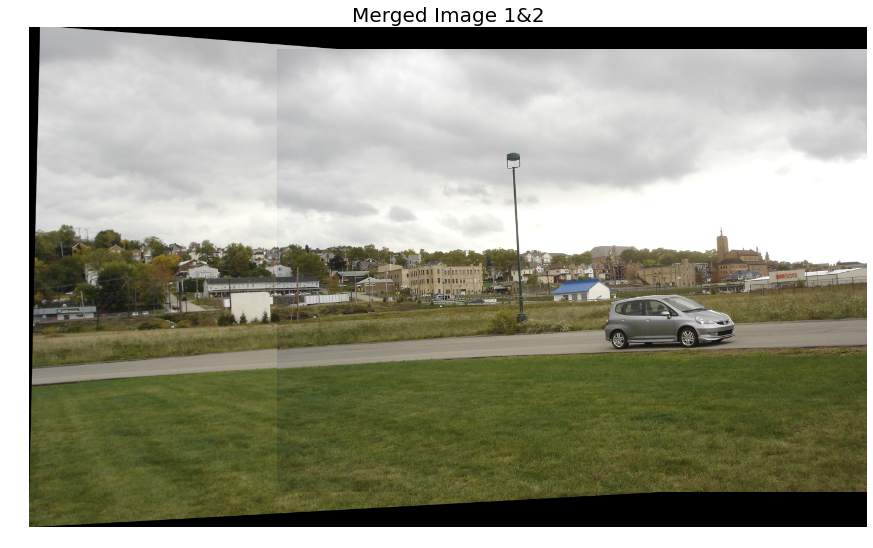

In [37]:
# Reference: http://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective/20355545#20355545
def warpTwoImages(img1, img2, H):
    h1,w1,t1 = img1.shape
    h2,w2,t2 = img2.shape
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_H = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_H), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel())
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel())
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2
    return result

peno_12 = warpTwoImages(img1_c, img2_c, H)
display(peno_12,'Merged Image 1&2')

### Image Blending
First, create two same-sized large canvas for the projected image 1&2 respectively, with 0 on none image area. Then create 2 binary masks of each canvas, and 1 mask for the intersection area.

Image Canvas and Masks:


(-0.5, 1419.5, 847.5, -0.5)

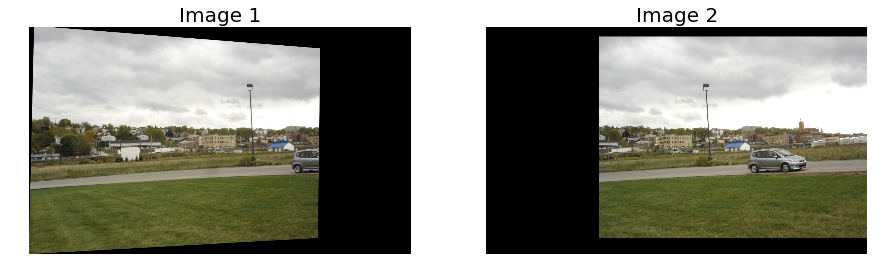

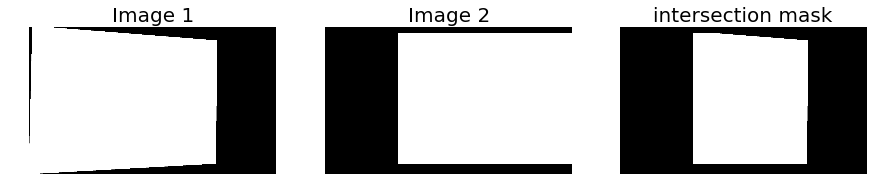

In [66]:
h1,w1,t1 = img1_c.shape
h2,w2,t2 = img2_c.shape
pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
pts2_H = cv2.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_H), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel())
[xmax, ymax] = np.int32(pts.max(axis=0).ravel())
t = [-xmin,-ymin]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
img1_canv = np.float64(cv2.warpPerspective(img1_c, Ht.dot(H), (xmax-xmin, ymax-ymin)))
img1_mask = img1_canv.copy()
img1_mask[img1_mask > 0] = 1
img2_canv = np.zeros((ymax-ymin,xmax-xmin,3))   
img2_canv[t[1]:h1+t[1],t[0]:w1+t[0]] = img2_c
img2_mask = img2_canv.copy()
img2_mask[img2_mask > 0] = 1
inter_mask = img1_mask * img2_mask

print 'Image Canvas and Masks:'
f, axes = plt.subplots(ncols=2, figsize=(15,15))
read_show_image(np.uint8(img1_canv),1)
read_show_image(np.uint8(img2_canv),2)
f, axes = plt.subplots(ncols=3, figsize=(15,15))
read_show_image(img1_mask,1)
read_show_image(img2_mask,2)
axes[2].imshow(inter_mask, cmap = cm.Greys_r)
axes[2].set_title('intersection mask',fontsize=20)
axes[2].axis('off')

Then build Laplacian Pyramid LA and LB from image canvas 1&2, and Gaussian Pyramid GA and GB from image mask 1&2, and GM from intersection mask.
At last, linearly combine all the five elements:

$LS = GA*LA*(1-w1*GM)+ GB*LB*(1-w2*GM)$ 

where $w1$ and $w2$ are weights that we played with.

The result showed that this method did not much improved the stitching line, probably because the use of intersection mask. Another way is feathering instead of pyramid blending.

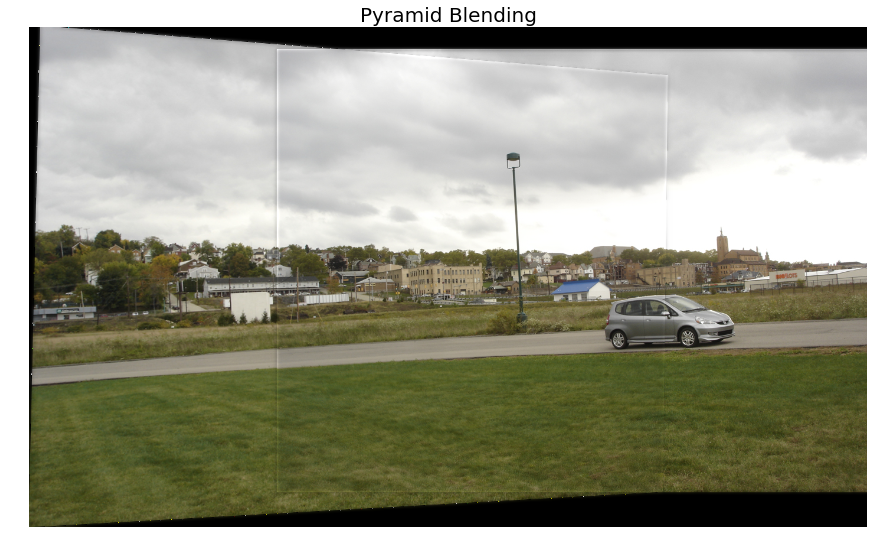

In [55]:
n = 3

def gaussian_pyramid(img):
    # generate Gaussian pyramid for img
    G = img.copy()
    img_gp = [G]
    for i in xrange(n):
        G = cv2.pyrDown(G)
        img_gp.append(G)
    return img_gp

def laplacian_pyramid(gp):
    lp = [gp[n-1]]
    for i in xrange(n-1,0,-1):
        GE = cv2.pyrUp(gp[i])
        L = cv2.subtract(gp[i-1],GE)
        lp.append(L)
    return lp

gpA = gaussian_pyramid(img1_canv)
gpB = gaussian_pyramid(img2_canv)
gpC = gaussian_pyramid(img1_mask)
gpD = gaussian_pyramid(img2_mask)
gpE = gaussian_pyramid(inter_mask)

lpA = laplacian_pyramid(gpA)
lpB = laplacian_pyramid(gpB)

# Now add left and right halves of images in each level
LS = []
for i,la in enumerate(lpA):
    xa = gpC[n-1-i]*la*(1-0.7*gpE[n-1-i])
    xb = gpD[n-1-i]*lpB[i]*(1-0.3*gpE[n-1-i])
    ls = cv2.add(xa,xb)
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in xrange(1,n):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])
    
ls_[ls_ > 255] = 255
display(np.uint8(ls_),'Pyramid Blending')

### Generalizing to more images
The idea of implementing to three or more images is that, first compute the homograph matrixes between each pairs (H12, H13, H23, H14,…), and then compute the large canvas size with all the Homography images, and then using image 3 as a still image, and then project image 1 and image 2 based on H12, H23 and H13. The result is not shown here, but the code is just for reference. 

In [3]:
def computeH(img1,img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    print 'Number of matches: ',len(matches)
    matches = sorted(matches, key = lambda x:x.distance)
    if len(matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
        Homo, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    else:
        print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
        Homo = None
    return Homo

In [ ]:
H23 = computeH(img2,img3)
peno_23 = warpTwoImages(img2_c, img3_c, H23)
H13 = H*H23
peno_13 = warpTwoImages(img1_c, img3_c, H13)
print peno_13.shape
display(peno_23,'Merged Images 2&3')

In [ ]:
def warpThreeImages(img1, img2, img3, H12, H23):
    h1,w1 = img1.shape
    h2,w2 = img2.shape
    h3,w3 = img3.shape
    H13 = H*H23
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts3 = np.float32([[0,0],[0,h3],[w3,h3],[w3,0]]).reshape(-1,1,2)
    pts2_H = cv2.perspectiveTransform(pts2, H)
    pts3_H = cv2.perspectiveTransform(pts3, H13)
    pts = np.concatenate((pts1, pts2_H, pts3_H), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel())
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel())
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result1 = cv2.warpPerspective(img1, Ht.dot(H13), (xmax-xmin, ymax-ymin))
    result2 = cv2.warpPerspective(img2, Ht.dot(H23), (xmax-xmin, ymax-ymin))
    result2[t[1]:h2+t[1],t[0]:w2+t[0]] = img3
    display(result,'result')
    
warpThreeImages(img1_c,img2_c,img3_c,H,H23)